In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import math

from keras.losses import mean_squared_error, mean_absolute_error
import seaborn as sns
from pylab import rcParams, concatenate
from pandas import concat
from keras.models import load_model
from matplotlib.font_manager import _rebuild
# import matplotlib.pyplot as plt

import matplotlib
from sklearn.metrics import r2_score

matplotlib.matplotlib_fname()

pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

warnings.simplefilter('ignore')

# get_ipython().run_line_magic('matplotlib', 'inline')

# sns.set(style='darkgrid', palette='muted')
sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})

color_scheme = {
    'red': '#F1637A',
    'green': '#6ABB3E',
    'blue': '#3D8DEA',
    'black': '#000000'
}

# 增加图片大小
rcParams['figure.figsize'] = 8, 6

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# 处理数据，最终要让数据的格式都是500个销售列和每天一行，如果不这么做，怎么预测到每个店，每个商品的销售呢？

df_train.head()

df_train.index = pd.to_datetime(df_train['date'])
df_train.drop('date', axis=1, inplace=True)
df_test.index = pd.to_datetime(df_test['date'])
df_test.drop('date', axis=1, inplace=True)

from itertools import product, starmap


def storeitems():
    return product(range(1, 51), range(1, 11))


def storeitems_column_names():
    return list(starmap(lambda i, s: f'item_{i}_store_{s}_sales', storeitems()))


def sales_by_storeitem(df):
    ret = pd.DataFrame(index=df.index.unique())
    for i, s in storeitems():
        ret[f'item_{i}_store_{s}_sales'] = df[(df['item'] == i) & (df['store'] == s)]['sales'].values
    return ret

df_train = sales_by_storeitem(df_train)
# 对于测试集，我们只是用0填充y值
df_test['sales'] = np.zeros(df_test.shape[0])
df_test = sales_by_storeitem(df_test)

# 数据组合起来为模型做准备，然后将其分解为训练集和测试集。

# 确保所有列名都是相同的，并且顺序相同
col_names = list(zip(df_test.columns, df_train.columns))
for cn in col_names:
    assert cn[0] == cn[1]

df_test['is_test'] = np.repeat(True, df_test.shape[0])
df_train['is_test'] = np.repeat(False, df_train.shape[0])
df_total = pd.concat([df_train, df_test])
df_total.info()

df_total.head()

# ### 特征工程
# 使用One-hot编码日，一周和一个月，以确保网络识别数据的季节性。

weekday_df = pd.get_dummies(df_total.index.weekday, prefix='weekday')
weekday_df.index = df_total.index

month_df = pd.get_dummies(df_total.index.month, prefix='month')
month_df.index = df_total.index

df_total = pd.concat([weekday_df, month_df, df_total], axis=1)

assert df_total.isna().any().any() == False


# 如果是单步预测我们还希望将前一天的sales追加到每一行，然后将其用作输入数据。
def shift_series(series, days):
    return series.transform(lambda x: x.shift(days))


def shift_series_in_df(df, series_names=[], days_delta=90):
    ret = pd.DataFrame(index=df.index.copy())
    str_sgn = 'future' if np.sign(days_delta) < 0 else 'past'
    for sn in series_names:
        ret[f'{sn}_{str_sgn}_{np.abs(days_delta)}'] = shift_series(df[sn], days_delta)
    return ret


def stack_shifted_sales(df, days_deltas=[1, 90, 360]):
    names = storeitems_column_names()
    dfs = [df.copy()]
    for delta in days_deltas:
        shifted = shift_series_in_df(df, series_names=names, days_delta=delta)
        dfs.append(shifted)
    return pd.concat(dfs, axis=1, sort=False, copy=False)

df_total = stack_shifted_sales(df_total, days_deltas=[1])
df_total.dropna(inplace=True)


# 我们需要确保堆叠和非堆叠后的数据的销售列以相同的顺序排列。通过对名称(作为字符串)进行排序来实现这一点

sales_cols = [col for col in df_total.columns if '_sales' in col and '_sales_' not in col]
stacked_sales_cols = [col for col in df_total.columns if '_sales_' in col]
other_cols = [col for col in df_total.columns if col not in set(sales_cols) and col not in set(stacked_sales_cols)]

sales_cols = sorted(sales_cols)
stacked_sales_cols = sorted(stacked_sales_cols)

new_cols = other_cols + stacked_sales_cols + sales_cols

df_total = df_total.reindex(columns=new_cols)

df_total.head()

assert df_total.isna().any().any() == False

Using TensorFlow backend.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1915 entries, 2015-01-01 to 2020-03-31
Columns: 501 entries, item_1_store_1_sales to is_test
dtypes: bool(1), float64(500)
memory usage: 7.3 MB


In [2]:
df_total.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
date,,,,,,,,,,,,,
2015-01-02,0,0,0,0,1,0,...,21.0,20.0,17.0,20.0,28.0,36.0
2015-01-03,0,0,0,0,0,1,...,25.0,15.0,28.0,18.0,31.0,25.0
2015-01-04,0,0,0,0,0,0,...,37.0,20.0,33.0,24.0,46.0,31.0
2015-01-05,1,0,0,0,0,0,...,37.0,23.0,27.0,14.0,35.0,30.0
2015-01-06,0,1,0,0,0,0,...,37.0,29.0,20.0,24.0,34.0,35.0


In [3]:
cols_to_scale = [col for col in df_total.columns if 'weekday' not in col and 'month' not in col]

In [4]:
df_total[cols_to_scale]

,is_test,item_10_store_10_sales_past_1,item_10_store_1_sales_past_1,item_10_store_2_sales_past_1,item_10_store_3_sales_past_1,item_10_store_4_sales_past_1,...,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
date,,,,,,,,,,,,,
2015-01-02,False,45.0,37.0,51.0,38.0,30.0,...,21.0,20.0,17.0,20.0,28.0,36.0
2015-01-03,False,50.0,34.0,56.0,60.0,29.0,...,25.0,15.0,28.0,18.0,31.0,25.0
2015-01-04,False,53.0,32.0,46.0,50.0,37.0,...,37.0,20.0,33.0,24.0,46.0,31.0
2015-01-05,False,51.0,45.0,56.0,46.0,45.0,...,37.0,23.0,27.0,14.0,35.0,30.0
2015-01-06,False,54.0,35.0,53.0,46.0,52.0,...,37.0,29.0,20.0,24.0,34.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-27,True,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-28,True,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-29,True,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
new_df = df_total[cols_to_scale]

In [6]:
new_df.item_10_store_10_sales_past_1

date
2015-01-02    45.0
2015-01-03    50.0
2015-01-04    53.0
2015-01-05    51.0
2015-01-06    54.0
              ... 
2020-03-27     0.0
2020-03-28     0.0
2020-03-29     0.0
2020-03-30     0.0
2020-03-31     0.0
Name: item_10_store_10_sales_past_1, Length: 1914, dtype: float64

In [7]:
import seaborn as sns

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

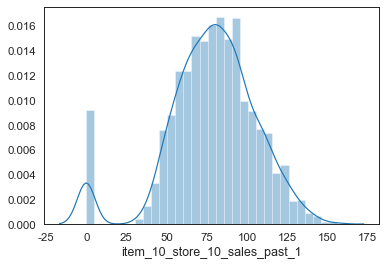

In [9]:
sns.distplot(new_df.item_10_store_10_sales_past_1);

In [10]:
df1=new_df.loc[:,['date','item_10_store_10_sales_past_1']]

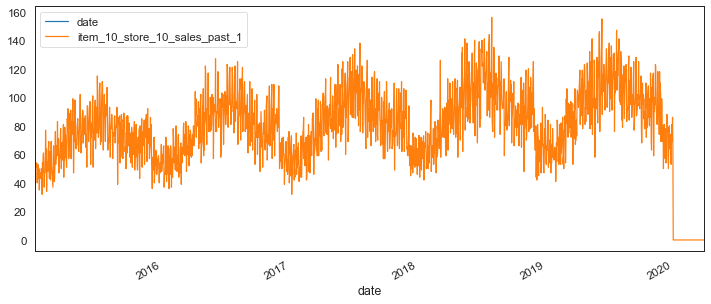

In [11]:
df1.plot(figsize=(12,5))

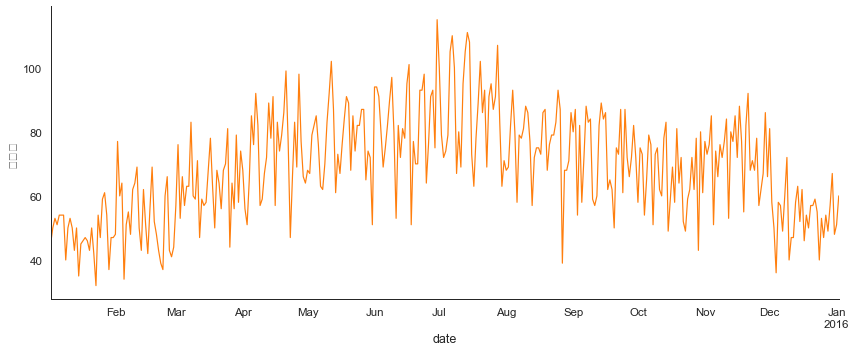

In [12]:
df2=df1.loc['2015-01-02':'2016-01-02',['date','item_10_store_10_sales_past_1']]
df2.plot(figsize=(12,5))
plt.ylabel('销售量')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

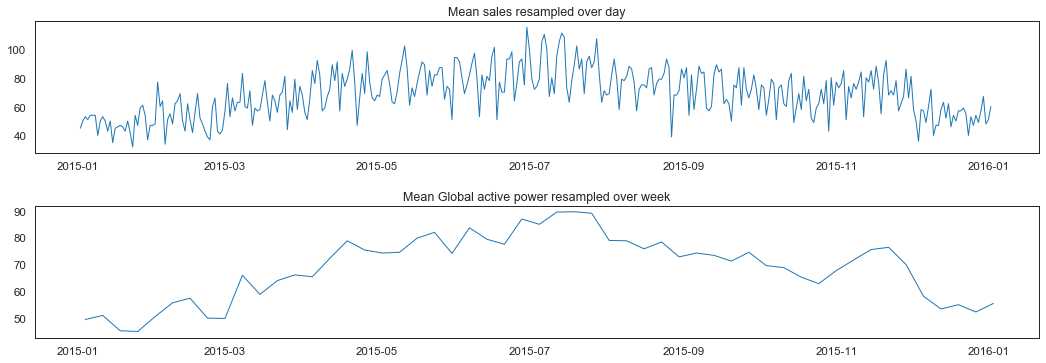

In [13]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df2['item_10_store_10_sales_past_1'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean sales resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df2['item_10_store_10_sales_past_1'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

In [14]:
df2.head()

,date,item_10_store_10_sales_past_1
date,,
2015-01-02,nan,45.0000
2015-01-03,nan,50.0000
2015-01-04,nan,53.0000
2015-01-05,nan,51.0000
2015-01-06,nan,54.0000


In [15]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Conv1D, Input, Dropout, AvgPool1D, Reshape, Concatenate

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
cols_to_scale = [col for col in df_total.columns if 'weekday' not in col and 'month' not in col]
scaled_cols = scaler.fit_transform(df_total[cols_to_scale])
df_total[cols_to_scale] = scaled_cols

In [18]:
df_train = df_total[df_total['is_test'] == False].drop('is_test', axis=1)
df_test = df_total[df_total['is_test'] == True].drop('is_test', axis=1)

In [19]:
X_cols_stacked = [col for col in df_train.columns if '_past_' in col]
X_cols_caldata = [col for col in df_train.columns if 'weekday_' in col or 'month_' in col or 'year' in col]
X_cols = X_cols_stacked + X_cols_caldata

In [20]:
X = df_train[X_cols]

X_colset = set(X_cols)
y_cols = [col for col in df_train.columns if col not in X_colset]

y = df_train[y_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

# 使用2019年第一季度进行验证
X_valid, y_valid = X_valid.head(90), y_valid.head(90)

# 对于Keras，需要对输入值进行进一步的转换，才能够输入到模型中
X_train_vals = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

In [21]:
print(X_valid_vals)

[[[0.56410256 0.48091603 0.49142857 ... 0.         0.         0.        ]]

 [[0.50641026 0.40458015 0.50857143 ... 0.         0.         0.        ]]

 [[0.3525641  0.38931298 0.25142857 ... 0.         0.         0.        ]]

 ...

 [[0.44871795 0.52671756 0.55428571 ... 0.         0.         0.        ]]

 [[0.44871795 0.52671756 0.60571429 ... 0.         0.         0.        ]]

 [[0.53846154 0.45801527 0.51428571 ... 0.         0.         0.        ]]]


In [22]:
print(X_valid)

            item_10_store_10_sales_past_1  item_10_store_1_sales_past_1  \
date                                                                      
2019-01-01                         0.5641                        0.4809   
2019-01-02                         0.5064                        0.4046   
2019-01-03                         0.3526                        0.3893   
2019-01-04                         0.3397                        0.4046   
2019-01-05                         0.4231                        0.3511   
...                                   ...                           ...   
2019-03-27                         0.6795                        0.6794   
2019-03-28                         0.4295                        0.4580   
2019-03-29                         0.4487                        0.5267   
2019-03-30                         0.4487                        0.5267   
2019-03-31                         0.5385                        0.4580   

            item_10_stor

In [23]:
print(X_valid.item_10_store_10_sales_past_1)
print(X_valid.shape[0])

date
2019-01-01   0.5641
2019-01-02   0.5064
2019-01-03   0.3526
2019-01-04   0.3397
2019-01-05   0.4231
              ...  
2019-03-27   0.6795
2019-03-28   0.4295
2019-03-29   0.4487
2019-03-30   0.4487
2019-03-31   0.5385
Name: item_10_store_10_sales_past_1, Length: 90, dtype: float64
90


In [24]:
X_10_10 = X_valid.item_10_store_10_sales_past_1
X_10_10 = X_10_10.values.reshape((X_valid.shape[0], 1, 1))

In [25]:
print(X_10_10)

[[[0.56410256]]

 [[0.50641026]]

 [[0.3525641 ]]

 [[0.33974359]]

 [[0.42307692]]

 [[0.41025641]]

 [[0.40384615]]

 [[0.51282051]]

 [[0.53846154]]

 [[0.32692308]]

 [[0.37179487]]

 [[0.34615385]]

 [[0.40384615]]

 [[0.44871795]]

 [[0.3974359 ]]

 [[0.51923077]]

 [[0.30128205]]

 [[0.42948718]]

 [[0.34615385]]

 [[0.42948718]]

 [[0.37179487]]

 [[0.5       ]]

 [[0.44230769]]

 [[0.38461538]]

 [[0.36538462]]

 [[0.35897436]]

 [[0.38461538]]

 [[0.41666667]]

 [[0.40384615]]

 [[0.3974359 ]]

 [[0.26282051]]

 [[0.34615385]]

 [[0.43589744]]

 [[0.3525641 ]]

 [[0.53846154]]

 [[0.52564103]]

 [[0.44871795]]

 [[0.42307692]]

 [[0.46153846]]

 [[0.33974359]]

 [[0.41025641]]

 [[0.37179487]]

 [[0.51923077]]

 [[0.48076923]]

 [[0.33974359]]

 [[0.52564103]]

 [[0.39102564]]

 [[0.42948718]]

 [[0.44230769]]

 [[0.52564103]]

 [[0.55128205]]

 [[0.33974359]]

 [[0.37179487]]

 [[0.32051282]]

 [[0.49358974]]

 [[0.49358974]]

 [[0.55769231]]

 [[0.55128205]]

 [[0.34615385]

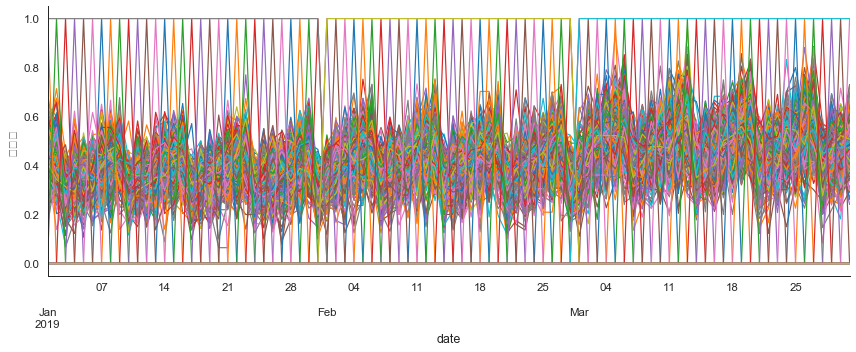

In [26]:
#CNN未处理的数据
# df_19=df1.loc['2015-01-02':'2016-01-02',['date','item_10_store_10_sales_past_1']]
X_valid.plot(figsize=(12,5))
plt.ylabel('销售量')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.savefig("CNN-pre-1.png", dpi=750, bbox_inches = "tight")
plt.show();

In [27]:
from keras.models import load_model

model = load_model('complex_history.h5')
model.summary()  # As a reminder.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 519)       0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1, 500)       260000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1, 500)       250500      dense_3[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 500)          2040000     input_1[0][0]                    
____________________________________________________________________________________________

In [28]:
from keras import models

In [29]:
layer_outputs = [layer.output for layer in model.layers[:1]]

In [30]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [31]:
activations = activation_model.predict(X_train_vals)

In [32]:
print(X_valid_vals)

[[[0.56410256 0.48091603 0.49142857 ... 0.         0.         0.        ]]

 [[0.50641026 0.40458015 0.50857143 ... 0.         0.         0.        ]]

 [[0.3525641  0.38931298 0.25142857 ... 0.         0.         0.        ]]

 ...

 [[0.44871795 0.52671756 0.55428571 ... 0.         0.         0.        ]]

 [[0.44871795 0.52671756 0.60571429 ... 0.         0.         0.        ]]

 [[0.53846154 0.45801527 0.51428571 ... 0.         0.         0.        ]]]


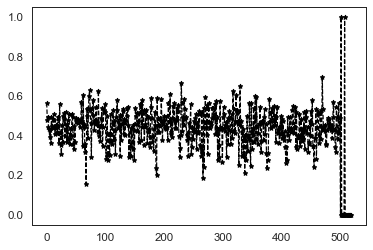

In [33]:
plt.plot(X_valid_vals[0][0], linestyle='--', marker='*', color='black',label='LSTM-Predicted')

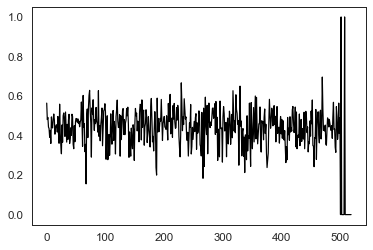

In [34]:
plt.plot(X_valid_vals[0][0], color='black')
plt.savefig("原始数据.png", dpi=750, bbox_inches = "tight")

In [35]:
print(activations)

[[[0.28846154 0.28244275 0.29142857 ... 0.         0.         0.        ]]

 [[0.32051283 0.259542   0.32       ... 0.         0.         0.        ]]

 [[0.33974358 0.24427481 0.26285714 ... 0.         0.         0.        ]]

 ...

 [[0.3653846  0.2519084  0.40571427 ... 0.         0.         1.        ]]

 [[0.5        0.46564886 0.4857143  ... 0.         0.         1.        ]]

 [[0.41025642 0.45801526 0.42857143 ... 0.         0.         1.        ]]]


In [36]:
first_layer_activation = activations[0]

In [37]:
print(first_layer_activation.shape)

(1, 519)


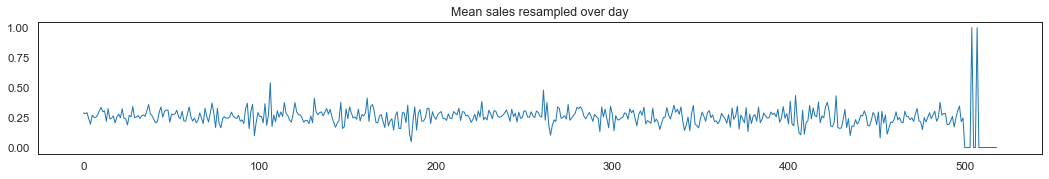

In [38]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax_output = fig.add_subplot(5,1,1)
ax_output.plot(first_layer_activation[0],linewidth=1)
ax_output.set_title('Mean sales resampled over day')
ax_output.tick_params(axis='both', which='major')

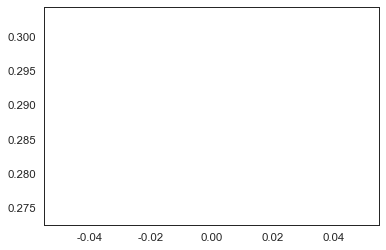

In [39]:
plt.plot(first_layer_activation[0][0])

In [40]:
from keras import backend as K

In [41]:
layer_1 = K.function([model.layers[0].input], [model.layers[1].output])#第一个 model.layers[0],不修改,表示输入数据；第二个model.layers[you wanted],修改为你需要输出的层数的编号
f1 = layer_1(X_valid_vals)

In [42]:
print(len(f1))
print(f1[0][0][0][:90])

1
[ 3.4748354  -3.5274754   3.7796211   1.0935699   3.6600277   3.4845922
  4.9091167  -3.7093322  -3.7654216  -0.99088067  3.3393347   2.795099
 -4.7087007   5.1550117  -3.4497447   3.892592    3.747361    2.978525
 -4.046439    4.8406653  -5.94276     3.383462   -2.8080983   5.0155406
  1.0338571   3.6148436  -4.721747   -5.9185214   5.210684    4.731586
 -4.716634   -3.6251323   4.458105    4.978157    0.11235355 -3.2255495
 -3.2204955   4.6234365  -3.5168202  -4.0913887   3.3754709   5.0998263
  3.0556905  -2.171279   -2.2796576  -3.276743    5.7361245   3.9752836
  3.399314    2.6627085   3.506857   -6.6688943  -5.569851   -5.24595
  3.1902187   4.8600736  -3.6094806   3.4575155   5.219624    3.3936393
 -4.95098     5.1014576   3.8407016  -4.822641    3.4550169   3.305648
 -3.0326226  -3.39152    -4.517545   -3.607756    2.3768094  -3.4670575
  1.9688039  -1.6911626   3.7272906  -2.9350305   3.3535128   2.9779267
  3.0212574  -3.6598594  -4.8482304   3.2795255   3.3487804  -2.9832

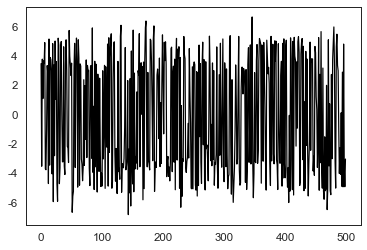

In [43]:
plt.plot(f1[0][0][0], color='black')
plt.savefig("CNN-pred-1-dense_3.png", dpi=750, bbox_inches = "tight")

In [44]:
print(f1)

[array([[[ 3.4748354, -3.5274754,  3.7796211, ..., -3.5372932,
         -4.9244576, -3.0358467]],

       [[ 3.5824258, -3.3316102,  3.5791647, ..., -3.465336 ,
         -4.981941 , -2.8531508]],

       [[ 2.248824 , -2.2250912,  2.4008884, ..., -2.2370346,
         -3.3445017, -1.967159 ]],

       ...,

       [[ 3.6437786, -3.6454444,  3.839068 , ..., -3.5593793,
         -5.1428633, -2.9259658]],

       [[ 3.5541077, -3.643087 ,  3.9673   , ..., -3.500621 ,
         -5.0746355, -2.9245865]],

       [[ 3.855236 , -3.8434286,  4.3426566, ..., -3.8210266,
         -5.4507256, -3.2239168]]], dtype=float32)]


In [45]:
layer_2 = K.function([model.layers[0].input], [model.layers[2].output])#第一个 model.layers[0],不修改,表示输入数据；第二个model.layers[you wanted],修改为你需要输出的层数的编号
f2 = layer_2(X_valid_vals)

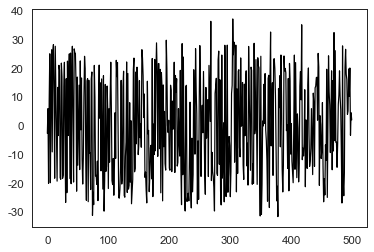

In [46]:
plt.plot(f2[0][0][0], color='black')
plt.savefig("CNN-pred-2-conv1d_1 (Conv1D).png", dpi=750, bbox_inches = "tight")

In [47]:
layer_3 = K.function([model.layers[0].input], [model.layers[3].output])#第一个 model.layers[0],不修改,表示输入数据；第二个model.layers[you wanted],修改为你需要输出的层数的编号
f3 = layer_3(X_valid_vals)

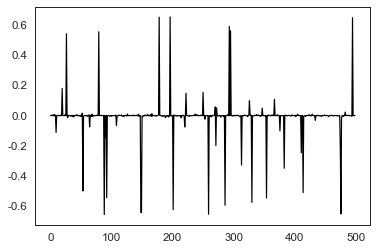

In [48]:
plt.plot(f3[0][0], color='black')
plt.savefig("CNN-pred-3-LSTM.png", dpi=750, bbox_inches = "tight")

In [49]:
layer_4 = K.function([model.layers[0].input], [model.layers[4].output])#第一个 model.layers[0],不修改,表示输入数据；第二个model.layers[you wanted],修改为你需要输出的层数的编号
f4 = layer_4(X_valid_vals)

In [ ]:
plt.plot(f4[0][0][0], color='black')
plt.savefig("CNN-pred-4-conv1d_2.png", dpi=750, bbox_inches = "tight")

In [ ]:
layer_5 = K.function([model.layers[0].input], [model.layers[5].output])#第一个 model.layers[0],不修改,表示输入数据；第二个model.layers[you wanted],修改为你需要输出的层数的编号
f5 = layer_5(X_valid_vals)

In [ ]:
plt.plot(f5[0][0], color='black')
plt.savefig("CNN-pred-5-dense_2.png", dpi=750, bbox_inches = "tight")

In [ ]:
layer_6 = K.function([model.layers[0].input], [model.layers[6].output])#第一个 model.layers[0],不修改,表示输入数据；第二个model.layers[you wanted],修改为你需要输出的层数的编号
f6 = layer_6(X_valid_vals)

In [ ]:
plt.plot(f6[0][0][0])
plt.savefig("CNN-pred-6-dense_2.png", dpi=750, bbox_inches = "tight")
print(f6)

In [ ]:
layer_7 = K.function([model.layers[0].input], [model.layers[7].output])#第一个 model.layers[0],不修改,表示输入数据；第二个model.layers[you wanted],修改为你需要输出的层数的编号
f7 = layer_7(X_valid_vals)

In [ ]:
plt.plot(f7[0][0],color='black')
plt.savefig("CNN-pred-7-dropout_1.png", dpi=750, bbox_inches = "tight")

In [ ]:
layer_9 = K.function([model.layers[0].input], [model.layers[9].output])#第一个 model.layers[0],不修改,表示输入数据；第二个model.layers[you wanted],修改为你需要输出的层数的编号
f9 = layer_9(X_valid_vals)

In [ ]:
plt.plot(f9[0][0],color='black')
plt.savefig("CNN-pred-9-concatenate_1.png", dpi=750, bbox_inches = "tight")

In [ ]:
layer_10 = K.function([model.layers[0].input], [model.layers[10].output])#第一个 model.layers[0],不修改,表示输入数据；第二个model.layers[you wanted],修改为你需要输出的层数的编号
f10 = layer_10(X_valid_vals)

In [ ]:
plt.plot(f10[0][0],color='black')
plt.savefig("CNN-pred-10-dense_4.png", dpi=750, bbox_inches = "tight")

In [ ]:
import seaborn as sns

sns.distplot(f10[0][0]);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(f10[0][0])))
print( 'Skewness of normal distribution: {}'.format(stats.skew(f10[0][0])))
plt.title('CNN处理后的数据正态性检测')
plt.savefig("LSTM-正态性检测.png", dpi=750, bbox_inches = "tight")

In [ ]:
sns.distplot(X_valid_vals[0][0])
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(X_valid_vals[0][0])))
print( 'Skewness of normal distribution: {}'.format(stats.skew(X_valid_vals[0][0])))
plt.title('原始数据正态性检测')
plt.savefig("CNN-LSTM-正态性检测.png", dpi=750, bbox_inches = "tight")

In [ ]:
# def test_stationarity(timeseries):
#     rolmean = timeseries.rolling(window=30).mean()
#     rolstd = timeseries.rolling(window=30).std()
# 
#     plt.figure(figsize=(14,5))
#     sns.despine(left=True)
#     orig = plt.plot(timeseries, color='blue',label='Original')
#     mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
# 
#     plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
#     plt.show()
# 
#     print ('<Results of Dickey-Fuller Test>')
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4],
#                          index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print(dfoutput)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf  #自相关图
from statsmodels.tsa.stattools import adfuller as ADF  #平稳性检测
from statsmodels.graphics.tsaplots import plot_pacf    #偏自相关图
from statsmodels.stats.diagnostic import acorr_ljungbox    #白噪声检验



In [ ]:
plot_acf(X_valid_vals[0][0]).show()
plt.xlabel('延迟时期数')
plt.ylabel('自相关系数')
plt.title('原始数据平稳性检测')
# plt.legend()
plt.savefig("LSTM-平稳性检测.png", dpi=750, bbox_inches = "tight")

In [ ]:
plot_acf(f10[0][0]).show()
plt.xlabel('延迟时期数')
plt.ylabel('自相关系数')
plt.title('CNN处理后的数据平稳性检测')
# plt.legend()
plt.savefig("CNN-LSTM-平稳性检测.png", dpi=750, bbox_inches = "tight")

In [ ]:
print(u'原始序列的ADF检验结果为：', ADF(X_valid_vals[0][0]))
print(u'CNNc处理后的序列的ADF检验结果为：', ADF(f10[0][0]))

In [ ]:
print(u'原始序列的白噪声检验结果为：', acorr_ljungbox(X_valid_vals[0][0], lags=1))
print(u'CNNc处理后的序列序列的白噪声检验结果为：', acorr_ljungbox(f10[0][0], lags=1))

In [ ]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

